In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn

In [2]:
datasetNames = ["CIFAR10", "MNIST", "FashionMNIST","Moon_Craters"] 

In [3]:
code = 2
BATCH_SIZE=4

In [4]:

if code ==1:
    NUM_CHANNELS = 3

    transform = transforms.Compose(
    
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])
    


    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=2)



if code ==2:

    NUM_CHANNELS = 1


    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
        ])

    trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)


    testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

if code ==3:

    NUM_CHANNELS = 1


    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
        ])

    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)


    testset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)


(3, 36, 138)


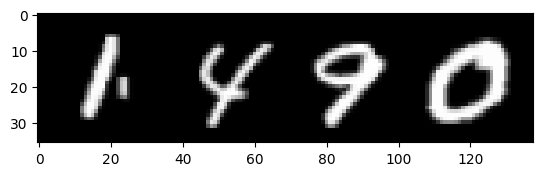

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an imageindices

def imshow(img):
    if code==1:
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, x):
        return nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)

In [7]:
class MyUnpool2d(nn.Module):
    def __init__(self, scale_factor):
        super(MyUnpool2d, self).__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return nn.functional.interpolate(x, scale_factor=self.scale_factor, mode='nearest')

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.conv1 = nn.Conv2d(NUM_CHANNELS, 64, 5)
        self.pool = nn.MaxPool2d(2, stride=2, return_indices=True)                                    
        self.conv2 = nn.Conv2d(64, 128, 5)

        
        self.fcEnc = nn.Sequential(
                                    nn.Linear(128 * 10 * 10, 120),
                                    nn.ReLU(True),
                                    nn.Linear(120, 84),
                                    nn.ReLU(True),
                                    nn.Linear(84, 40))
        

        self.unpool = nn.MaxUnpool2d(2, stride=2, padding=0)

        

        self.fcDec = nn.Sequential(
                                    nn.Linear(40, 84),
                                    nn.ReLU(True),
                                    nn.Linear(84, 120),
                                    nn.ReLU(True),
                                    nn.Linear(120, 128 * 10 * 10),
                                    nn.ReLU(True),
                                    nn.Unflatten(1, (128, 10, 10))

        )

        self.convt1 = nn.ConvTranspose2d(128, 64, 5)
        self.unpool = nn.MaxUnpool2d(2, 2)
                        
        
                                    
        self.convt2 =  nn.ConvTranspose2d(64, NUM_CHANNELS, 5)




    def forward(self, x):
        x = self.conv1(x)
        x,indices = self.pool(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.fcEnc(x)
        x = self.fcDec(x)
        # print(x.shape)

        x = F.relu(self.convt1(x))
        x = self.unpool(x,indices)
        x = F.sigmoid( self.convt2(x))
        
        # print(x.shape)
        return x


    def compress(self,x):
        x = self.conv1(x)
        x,indices = self.pool(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.fcEnc(x)
        return x , indices
    
    def decompress(self,compressed,indices):
        x = self.fcDec(compressed)

        x = F.relu(self.convt1(x))
        x = self.unpool(x,indices)
        x = F.sigmoid( self.convt2(x))
        
        # print(x.shape)
        return x

net = Autoencoder()


In [9]:
# import torch.optim as optim

# criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
net.to(device)

Autoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fcEnc): Sequential(
    (0): Linear(in_features=12800, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=40, bias=True)
  )
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (fcDec): Sequential(
    (0): Linear(in_features=40, out_features=84, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=84, out_features=120, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=120, out_features=12800, bias=True)
    (5): ReLU(inplace=True)
    (6): Unflatten(dim=1, unflattened_size=(128, 10, 10))
  )
  (convt1): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (convt2):

In [12]:
input_data = torch.randn(1, NUM_CHANNELS, 32, 32).to(device)  # Example input tensor of shape (batch_size, channels, height, width)
output_data = net(input_data)  # Forward pass through the autoencoder
# loss = F.mse_loss(output_data, input_data)  # Compute MSE loss between output and input
# print(loss)

In [13]:
output_data.shape

torch.Size([1, 1, 32, 32])

In [14]:
from tqdm import tqdm

In [ ]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm



criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)


# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)  

for epoch in range(6):  

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        
        inputs, labels = data

        optimizer.zero_grad()
        
        outputs = net(inputs.to(device))
        loss = criterion(outputs, inputs.to(device))
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
        if i % 2000 == 1999:   
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    
    
    # scheduler.step()

print('Finished Training')


(3, 36, 138)


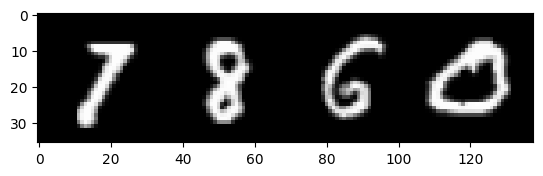

In [16]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [17]:
dataiter = iter(testloader)
images, labels = next(dataiter)

outputs = net(images.to(device))

In [18]:
outputs.shape

torch.Size([4, 1, 32, 32])

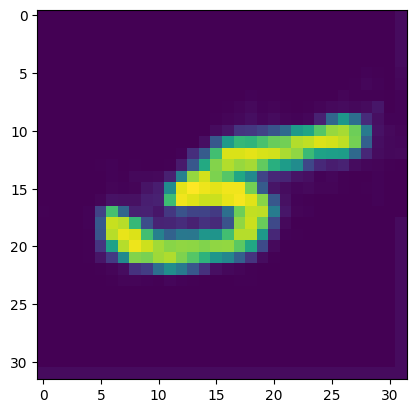

In [19]:
plt.imshow(outputs[3].detach().cpu().permute(1,2,0))

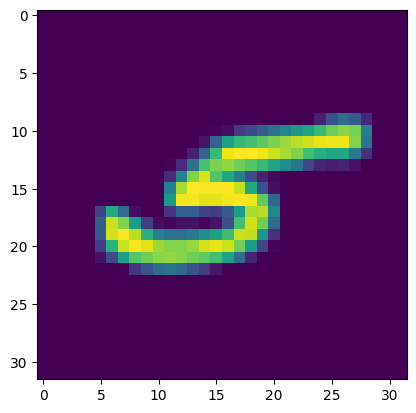

In [20]:
plt.imshow(images[3].detach().cpu().permute(1,2,0))

## Saving the Model

In [ ]:
from datetime import datetime
now = datetime.now()

In [ ]:
f'{now}'

In [ ]:
root = 'models'

In [ ]:
f'{loss.item():.4f}'

In [ ]:
f'{root}/{datasetNames[code-1]}-{now}-{loss.item():.4f}.pth'

In [ ]:
torch.save(net.state_dict(), f'{root}/{datasetNames[code-1]}-{now}-{loss.item():.4f}.pth')

## Loading the saved model

In [ ]:
    # print(outputs.shape)

    # tSSIM+=BSSIM
import os

print(f"Options Are: {os.listdir('models')}")

In [15]:
net.load_state_dict(torch.load(f'models/MNIST-2024-04-13 23:34:19.095483-0.0007.pth'))

<All keys matched successfully>

## Benchmarking on Test Dataset

In [21]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

criterion = nn.MSELoss()

running_loss = 0.0
for i, data in tqdm(enumerate(testloader, 0)):
    inputs, labels = data

    outputs = net(inputs.to(device))
    loss = criterion(outputs, inputs.to(device))


print(f'Test Loss: {loss.item()}')

2500it [00:01, 1702.62it/s]

Test Loss: 0.0009533369448035955


## SSIM

In [22]:
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim


criterion = nn.MSELoss()

running_loss = 0.0

tSSIM = 0

for i, data in tqdm(enumerate(trainloader, 0)):
    inputs, labels = data

    outputs = net(inputs.to(device))

    batchNumpyIP = inputs.permute((0,2,3,1)).detach().cpu().numpy()
    batchNumpyOP = outputs.permute((0,2,3,1)).detach().cpu().numpy()

    for i in range(BATCH_SIZE):
        ssim_index, _ = compare_ssim(batchNumpyIP[i,:,:,0], batchNumpyOP[i,:,:,0], full=True,win_size=5,data_range=1)
        tSSIM+=ssim_index

    loss = criterion(outputs, inputs.to(device))

print(f'Train Loss: {loss.item()}')
print(f'Mean MSSIM for Train data is: {tSSIM/(4*len(trainloader))}')


15000it [00:15, 968.17it/s]

Train Loss: 0.0006819096161052585
Mean MSSIM for Train data is: 0.9642008355064674


In [23]:
len(testloader)|

SyntaxError: invalid syntax (3617155048.py, line 1)

In [24]:
tSSIM

57852.050130388045

In [25]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

resFull = torch.tensor([])


running_loss = 0.0
for i, data in tqdm(enumerate(trainloader, 0)):
    inputs, labels = data

    outputs = net.compress(inputs.to(device))
    resFull = torch.cat([resFull, outputs[0].detach().cpu()], dim=0)


15000it [00:11, 1261.83it/s]


In [26]:
resFull.shape

torch.Size([60000, 40])

In [27]:
toSave = resFull.numpy()

In [28]:
np.save(f'{datasetNames[code-1]}-compressed.npy',toSave)

Saving Inputs / Untouched

In [29]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

resFull = torch.tensor([])


running_loss = 0.0
for i, data in tqdm(enumerate(trainloader, 0)):
    inputs, labels = data

    # outputs = net.compress(inputs.to(device))
    resFull = torch.cat([resFull, inputs], dim=0)


15000it [02:44, 91.22it/s] 


In [30]:
resFull.shape

torch.Size([60000, 1, 32, 32])

In [31]:
toSave = resFull.numpy()

In [32]:
np.save(f'{datasetNames[code-1]}-og.npy',toSave)